**Library Imports**

**Sets the stage by importing essential libraries.** 
    
    --`os`: Provides functions for interacting with the operating system (e.g., file path manipulation).
    --`numpy` (as `np`): Essential for numerical operations, especially handling arrays and matrices.
    --`tensorflow` (as `tf`): The core machine learning library used for building and training models.
    --`tensorflow.keras`: A high-level API for building and training neural networks within TensorFlow. Includes:
        --`layers`: Building blocks for neural networks (e.g., convolutional layers, dense layers).
        --`models`: Used to create and manage complete models.
        --`callbacks`: Utilities to control the training process (e.g., early stopping, model checkpointing).
    --`matplotlib.pyplot` (as `plt`): Used for creating visualizations, such as plots of training history.
    --`sklearn.metrics`: Provides tools for evaluating model performance, including:
        --`confusion_matrix`: Computes the confusion matrix to evaluate classification accuracy.
        --`classification_report`: Generates a detailed report of precision, recall, F1-score, etc.
        --`roc_auc_score`: Calculates the Area Under the Receiver Operating Characteristic Curve.
        --`precision_recall_curve`: Computes precision-recall pairs for different threshold values.
        --`auc`: Calculates the Area Under the Precision-Recall Curve.
        --`accuracy_score`: Calculates the accuracy of a classification model.
        --`f1_score`: Computes the F1-score, a weighted average of precision and recall.
        --`matthews_corrcoef`: Calculates the Matthews correlation coefficient for binary classification.
        --`cohen_kappa_score`: Computes Cohen's kappa, a measure of inter-rater agreement.
        --`roc_curve`: Computes the receiver operating characteristic curve.
    --`seaborn` (as `sns`): A library for creating more visually appealing statistical graphics.
    --`tqdm`: Provides a progress bar for loops, useful for monitoring training progress.
    --`gc`: The garbage collection module, used for manually freeing memory.

In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                             precision_recall_curve, auc, accuracy_score, f1_score, 
                             matthews_corrcoef, cohen_kappa_score, roc_curve)
import seaborn as sns
from tqdm import tqdm
import gc

In [2]:
# Optimize for CPU
tf.config.threading.set_inter_op_parallelism_threads(os.cpu_count())
tf.config.threading.set_intra_op_parallelism_threads(os.cpu_count())
print(f"CPU threads configured: {os.cpu_count()}")

CPU threads configured: 12


**Configuration Parameters**

**Establishes global configuration settings for audio processing and model training.** 

    --`SAMPLE_RATE`: The number of samples of audio carried per second (16000 Hz).
    --`MAX_DURATION`: The maximum duration of the audio clips to be used (2 seconds).
    --`BATCH_SIZE`: The number of samples processed in each batch during training (64).
    --`EPOCHS`: The number of complete passes through the training dataset (15).
    --`LEARNING_RATE`: The rate at which the model learns during training (0.002).
    --`PATIENCE`: The number of epochs with no improvement after which training will be stopped (5).
    --`AUDIO_LENGTH`: The total number of audio samples, calculated as `SAMPLE_RATE * MAX_DURATION`.
    --`N_FILTERS`: The number of filters in the SincConv layer (24).
    --`KERNEL_SIZE`: The size of the kernel in the SincConv layer (15).
    --`DATA_PATH`: The path to the directory containing the audio data ("data").
    --`MODEL_PATH`: The path where the trained model will be saved ("lcnn\_best\_model1.keras").
    --`gc.enable()`: Enables Python's garbage collector for automatic memory management.


In [25]:
# Configuration for Best Scores
SAMPLE_RATE = 16000
MAX_DURATION = 2    # Increased to 2 seconds
BATCH_SIZE = 64
EPOCHS = 15         # More epochs for convergence
LEARNING_RATE = 0.002  # Adjusted for better learning
PATIENCE = 5        # More patience
AUDIO_LENGTH = SAMPLE_RATE * MAX_DURATION
N_FILTERS = 24      # Increased for capacity
KERNEL_SIZE = 15
DATA_PATH = "data"
MODEL_PATH = "lcnn_best_model1.keras"

# Enable memory cleanup
gc.enable()

**Focal Loss Function**

**Implements the Focal Loss function to address class imbalance during training.** 

    --`focal_loss(gamma=1.5, alpha=0.5)`: This outer function defines the `gamma` and `alpha` parameters for the focal loss.
        --`gamma`: The focusing parameter, reducing the relative loss for well-classified examples.
        --`alpha`: A weighting factor to address class imbalance.
    --`focal_loss_fn(y_true, y_pred)`: This inner function calculates the focal loss.
        --`y_true`: The true labels (0 or 1).
        --`y_pred`: The predicted probabilities.
        --`tf.clip_by_value`: Clips the predicted values to avoid numerical instability.
        --`ce_loss`: Cross-entropy loss.
        --`p_t`: Probability of the true class.
        --`focal_weight`: The focal loss weight, which down-weights easy examples.

In [4]:
# Balanced Focal Loss
def focal_loss(gamma=1.5, alpha=0.5):  # Adjusted for balance
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tf.pow(1 - p_t, gamma)
        return tf.reduce_mean(alpha * focal_weight * ce_loss)
    return focal_loss_fn

**SincConv Layer**

**Creates a custom SincConv layer that learns bandpass filters directly from audio data.** 

--`SincConv(layers.Layer)`: A custom Keras layer that implements the SincConv functionality.

--`\_\_init\_\_`: Initializes the layer with the number of filters (`n_filters`), kernel size (`kernel_size`), and sample rate(`sample_rate`).

--`self.n`: A tensor containing indices from `-kernel_size // 2` to `kernel_size // 2`.

--`self.t`: A tensor representing the time axis.
-- `build`: Defines the trainable weights of the layer:
    
    --`self.low_hz`: Lower cutoff frequencies for the bandpass filters. Initialized randomly between 50 and 500 Hz.
    
    --`self.band_hz`: Bandwidth of the bandpass filters.  Initialized randomly between 50 and 500 Hz.

--`call`: Implements the forward pass of the layer.

-- Calculates the low and high cutoff frequencies.
    
    --Creates the Sinc filters using `tf.sin`.
    
    --Performs 1D convolution using `tf.nn.conv1d`.

--`compute_output_shape`: Computes the output shape of the layer.

In [5]:
# Lightweight SincConv Layer
class SincConv(layers.Layer):
    def __init__(self, n_filters, kernel_size, sample_rate, **kwargs):
        super(SincConv, self).__init__(**kwargs)
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate
        self.n = tf.range(-(self.kernel_size // 2), (self.kernel_size // 2) + 1, dtype=tf.float32)
        self.t = tf.cast(self.n / self.sample_rate, tf.float32)

    def build(self, input_shape):
        self.low_hz = self.add_weight(
            name='low_hz', shape=(self.n_filters,), 
            initializer=tf.random_uniform_initializer(50.0, 500.0), 
            trainable=True, dtype=tf.float32
        )
        self.band_hz = self.add_weight(
            name='band_hz', shape=(self.n_filters,), 
            initializer=tf.random_uniform_initializer(50.0, 500.0), 
            trainable=True, dtype=tf.float32
        )
        self.eps = tf.cast(1e-7, tf.float32)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        low = tf.abs(self.low_hz)
        high = tf.minimum(low + tf.abs(self.band_hz), self.sample_rate / 2 - 1)
        pi = tf.constant(np.pi, dtype=tf.float32)
        low_t = 2 * pi * low[:, None] * self.t
        high_t = 2 * pi * high[:, None] * self.t
        low_div = tf.where(tf.abs(low_t) < self.eps, tf.ones_like(low_t), low_t)
        high_div = tf.where(tf.abs(high_t) < self.eps, tf.ones_like(high_t), high_t)
        low_pass1 = tf.sin(low_t) / low_div
        low_pass2 = tf.sin(high_t) / high_div
        band_pass = low_pass2 - low_pass1
        filters = band_pass / tf.reduce_max(tf.abs(band_pass), axis=-1, keepdims=True)
        filters = tf.transpose(filters, [1, 0])
        filters = tf.expand_dims(filters, axis=1)
        x = tf.expand_dims(inputs, axis=-1)
        return tf.nn.conv1d(x, filters, stride=1, padding='SAME')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.n_filters)

**Audio Processing Function**

**Defines how audio files are processed: decoding, padding/truncating, and normalizing.** 

    --`process_audio(file_path)`: This function takes the file path of an audio file as input.
    --`tf.io.read_file(file_path)`: Reads the binary content of the audio file.
    --`tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=AUDIO_LENGTH)`: Decodes the WAV file. `desired_channels=1` specifies mono audio, and `desired_samples=AUDIO_LENGTH` truncates or pads the audio to the desired length.
    --`tf.squeeze(audio, axis=-1)`: Removes the channel dimension from the audio tensor.
    --`tf.cond`: A conditional statement that either truncates the audio if it's longer than `AUDIO_LENGTH` or pads it if it's shorter.
    --`tf.pad`: Pads the audio with zeros if it's shorter than `AUDIO_LENGTH`.
    --`Normalization`: Divides the audio by its maximum absolute value to scale the amplitude between -1 and 1.

In [7]:
# Enhanced Audio Processing with Normalization
@tf.function
def process_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=AUDIO_LENGTH)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cond(
        tf.shape(audio)[0] >= AUDIO_LENGTH, 
        lambda: audio[:AUDIO_LENGTH], 
        lambda: tf.pad(audio, [[0, AUDIO_LENGTH - tf.shape(audio)[0]]], mode='CONSTANT')
    )
    # Normalize audio
    audio = audio / (tf.reduce_max(tf.abs(audio)) + 1e-7)
    return tf.cast(audio, tf.float32)

**Dataset Creation**

**Generates a TensorFlow dataset from audio files, handling real and fake samples.** 

    --`create_dataset(data_path, augment=False, shuffle=True)`:  Creates a TensorFlow dataset from audio files.
        --`data_path`: Path to the directory containing "real" and "fake" subdirectories.
        --`augment`:  A boolean indicating whether to apply audio augmentation.
        --`shuffle`: A boolean indicating whether to shuffle the dataset.
    --`os.path.join`: Constructs file paths.
    --`os.listdir`: Lists files in a directory.
    --`tf.data.Dataset.from_tensor_slices`: Creates a dataset from tensors.
    --`dataset.shuffle`: Shuffles the dataset.
    --`map_fn(file_path, label)`: A mapping function that applies `process_audio` and optionally `augment_audio` to each audio file.

In [8]:
# Streamlined Dataset Creation
def create_dataset(data_path, augment=False, shuffle=True):
    real_dir = os.path.join(data_path, "real")
    fake_dir = os.path.join(data_path, "fake")
    
    if not os.path.exists(real_dir) or not os.path.exists(fake_dir):
        print(f"Warning: Directory not found. Real: {real_dir}, Fake: {fake_dir}")
        dummy_data = tf.zeros((1, AUDIO_LENGTH), dtype=tf.float32)
        dummy_labels = tf.zeros((1,), dtype=tf.int32)
        return tf.data.Dataset.from_tensor_slices((dummy_data, dummy_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav')]
    fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.wav')]
    print(f"Real samples: {len(real_files)}, Fake samples: {len(fake_files)}")
    
    file_paths = real_files + fake_files
    labels = [0] * len(real_files) + [1] * len(fake_files)
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(len(file_paths), 5000), reshuffle_each_iteration=True)
    
    def map_fn(file_path, label):
        audio = process_audio(file_path)
        if augment:
            audio = augment_audio(audio)
        return audio, tf.cast(label, tf.int32)
    
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

**Audio Augmentation**

**Implements data augmentation techniques to improve model generalization.**

    --`augment_audio(audio)`: This function takes an audio tensor as input and applies data augmentation.
    --`tf.random.normal`: Adds random noise to the audio.
    --`tf.roll`:  Shifts the audio signal randomly.
    --`tf.random.uniform`: Applies a random gain to the audio.
    --`Re-normalization`: Re-normalizes the audio after augmentation.

In [9]:
# Enhanced Audio Augmentation
@tf.function
def augment_audio(audio):
    noise = tf.random.normal(tf.shape(audio), stddev=0.01, dtype=tf.float32)
    audio = audio + noise
    shift = tf.random.uniform([], maxval=AUDIO_LENGTH // 10, dtype=tf.int32)
    audio = tf.roll(audio, shift, axis=0)
    gain = tf.random.uniform([], 0.8, 1.2, dtype=tf.float32)
    audio = audio * gain
    audio = audio / (tf.reduce_max(tf.abs(audio)) + 1e-7)  # Re-normalize
    return tf.cast(audio, tf.float32)

**LCNN Model Architecture**

**Defines the architecture of the Lightweight Convolutional Neural Network (LCNN) for deepfake detection** on


    --`build_lcnn_model(input_shape=(AUDIO_LENGTH,))`:  This function defines the LCNN model architecture.
    --`layers.Input`: Defines the input layer.
    --`SincConv`: The custom SincConv layer.
    --`layers.BatchNormalization`: Applies batch normalization.
    --`layers.Activation('relu')`: Applies ReLU activation.
    --`layers.Conv1D`: 1D convolutional layers.
    --`layers.MaxPooling1D`: Max pooling layers.
    --`layers.Dropout`: Dropout layers for regularization.
    --`layers.GlobalAveragePooling1D`: Global average pooling layer.
    --`layers.Dense`: Dense (fully connected) layers.
    --`tf.keras.optimizers.Adam`: The Adam optimizer.
    --`clipnorm`: Gradient clipping to prevent exploding gradients.

In [10]:
# Enhanced LCNN Model
def build_lcnn_model(input_shape=(AUDIO_LENGTH,)):
    inputs = layers.Input(shape=input_shape, dtype=tf.float32)
    x = SincConv(n_filters=N_FILTERS, kernel_size=KERNEL_SIZE, sample_rate=SAMPLE_RATE)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(16, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(4)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(4)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)  # Added layer
    x = layers.MaxPooling1D(4)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)  # Increased capacity
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, x)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)  # Gradient clipping
    model.compile(optimizer=optimizer, loss=focal_loss(gamma=1.5, alpha=0.5), 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

**Custom Callbacks and Learning Rate Schedule**

**Creates custom callbacks for logging validation metrics and implements a learning rate schedule.** 

    --FastMetricsCallback(callbacks.Callback)`: A custom callback to log validation metrics at the end of each epoch.
    -- `on_epoch_end`:  This method is called at the end of each epoch and logs validation accuracy, precision, and recall.
    --`simple_lr_schedule()`: Defines a learning rate schedule.
    --`scheduler(epoch, lr)`:  A function that returns the learning rate for a given epoch.  It decreases the learning rate after the 5th epoch.

In [11]:
# Enhanced Metrics Callback
class FastMetricsCallback(callbacks.Callback):
    def __init__(self, val_ds):
        super(FastMetricsCallback, self).__init__()
        self.val_ds = val_ds

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy', 0.0)
        val_prec = logs.get('val_precision', 0.0)
        val_rec = logs.get('val_recall', 0.0)
        print(f"Epoch {epoch + 1}/{EPOCHS} - Val Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}")

# Gradual Learning Rate Schedule
def simple_lr_schedule():
    def scheduler(epoch, lr):
        if epoch < 5:
            return LEARNING_RATE
        return LEARNING_RATE * (0.95 ** (epoch - 4))  # Slower decay
    return scheduler

**Model Training Function**

**Orchestrates the training process of the LCNN model.** 


    --`train_model()`:  This function trains the LCNN model.
    --`create_dataset`: Creates training and validation datasets.
    --Class weight calculation: Calculates class weights to address class imbalance.
    --`callbacks.EarlyStopping`: Stops training when a monitored metric has stopped improving.
    --`callbacks.ModelCheckpoint`: Saves the best model during training.
    --`callbacks.LearningRateScheduler`: Adjusts the learning rate during training.
    --`model.fit`: Trains the model.

In [12]:
# Optimized Training
def train_model():
    print("Creating datasets...")
    train_ds = create_dataset(os.path.join(DATA_PATH, "training"), augment=True, shuffle=True)
    val_ds = create_dataset(os.path.join(DATA_PATH, "validation"), augment=False, shuffle=False)
    
    class_counts = [0, 0]
    for _, labels in train_ds:
        unique, counts = np.unique(labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[u] += c
    total = sum(class_counts)
    class_weight = {i: total / (2 * count) if count > 0 else 1.0 
                    for i, count in enumerate(class_counts)}
    print(f"Class weights: {class_weight}")
    
    print("Building model...")
    model = build_lcnn_model()
    model.summary()
    
    callbacks_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
        callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True),
        callbacks.LearningRateScheduler(simple_lr_schedule()),
        FastMetricsCallback(val_ds)
    ]
    
    gc.collect()
    tf.keras.backend.clear_session()
    
    print(f"Starting training for {EPOCHS} epochs...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks_list,
        class_weight=class_weight,
        verbose=1
    )
    return model, history

**Main Execution Function**

**Manages the entire workflow: data setup, model training, saving, loading, and evaluation.**

    --`main()`: This is the main function that orchestrates the entire process.
    --`os.path.exists` and `os.makedirs`: Used to check if directories exist and create them if they don't.
    --`train_model()`: Calls the `train_model` function to train the model.
    --Plotting training history: Plots the training accuracy and loss.
    --`model.save`: Saves the trained model.
    --`tf.keras.models.load_model`: Loads the saved model.
    --`evaluate_model`: Evaluates the loaded model on the validation set.

In [27]:
# Main Execution
def main():
    print("Starting fastest CPU-only LCNN training...")
    print(f"TensorFlow version: {tf.__version__}")
    print(f"CPU threads: {os.cpu_count()}")
    
    if not os.path.exists(DATA_PATH):
        print(f"Warning: Data directory {DATA_PATH} not found. Creating dummy structure.")
        for split in ["training", "validation"]:
            for label in ["real", "fake"]:
                os.makedirs(os.path.join(DATA_PATH, split, label), exist_ok=True)
    
    # Train the model
    model, history = train_model()
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig("training_history.png", dpi=150)
    plt.close()
    
    # Save the trained model
    print(f"\nSaving model to {MODEL_PATH}...")
    model.save(MODEL_PATH)
    print(f"Model saved successfully!")
    
    # Load the saved model for evaluation
    print(f"\nLoading saved model from {MODEL_PATH} for evaluation...")
    saved_model = tf.keras.models.load_model(
        MODEL_PATH,
        custom_objects={'SincConv': SincConv, 'focal_loss_fn': focal_loss(gamma=1.5, alpha=0.5)}
    )
    print("Model loaded successfully!")
    
    # Evaluate using the saved model
    print("\nEvaluating on Validation Set with saved model:")
    val_ds = create_dataset(os.path.join(DATA_PATH, "validation"), augment=False, shuffle=False)
    evaluate_model(val_ds, saved_model)
    
    print("\nTraining, evaluation, and saving completed!")
    
    return model, history  # Optional: return model and history for further use

Starting fastest CPU-only LCNN training...
TensorFlow version: 2.18.0
CPU threads: 12
Creating datasets...
Real samples: 6978, Fake samples: 6978
Real samples: 1413, Fake samples: 1413
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Building model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sinc_conv (SincConv)                 │ (None, 32000, 24)           │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32000, 24)           │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32000, 24)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 32000, 16)           │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8000, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8000, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 8000, 32)            │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2000, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2000, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 2000, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,265 (51.82 KB)

 Non-trainable params: 48 (192.00 B)

Starting training for 15 epochs...
Epoch 1/15
Epoch 1/15 - Val Accuracy: 0.7413, Precision: 0.6685, Recall: 0.9575/step - accuracy: 0.8269 - loss: 0.1472 - precision: 0.4477 - recall: 0.3487          
219/219 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.8268 - loss: 0.1471 - precision: 0.4494 - recall: 0.3507 - val_accuracy: 0.7413 - val_loss: 0.0991 - val_precision: 0.6685 - val_recall: 0.9575 - learning_rate: 0.0020
Epoch 2/15
Epoch 2/15 - Val Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000/step - accuracy: 0.7819 - loss: 0.0792 - precision: 0.3666 - recall: 0.3858          
219/219 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.7817 - loss: 0.0793 - precision: 0.3681 - recall: 0.3879 - val_accuracy: 0.5000 - val_loss: 0.1378 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0020
Epoch 3/15
Epoch 3/15 - Val Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000/step - accuracy: 0.6645 - loss: 0.1170 - precision: 0.2938 - recall: 0.2625          
219/219 ━━━━━━━━━━━

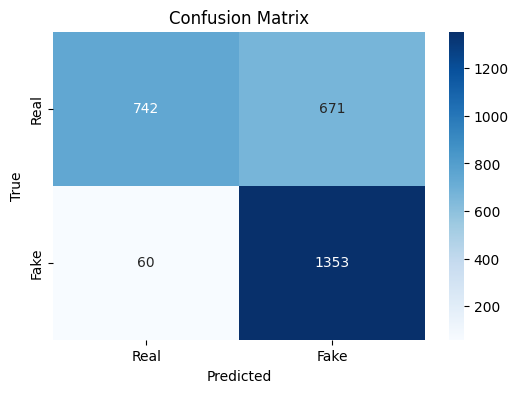

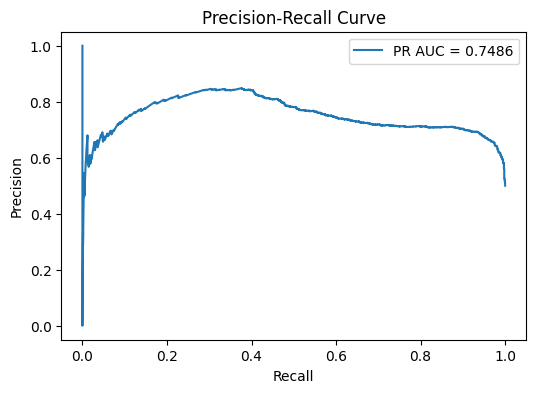


Training, evaluation, and saving completed!
(<Functional name=functional, built=True>, <keras.src.callbacks.history.History object at 0x000001E6E1EB8740>)


In [28]:
x = main()
print(x)

In [35]:
def evaluate_model(dataset, model):
    y_true, y_pred_binary, y_pred_proba = [], [], []
    
    # Collect predictions
    print("Collecting predictions...")
    for audio, labels in tqdm(dataset, desc="Evaluating"):
        preds = model.predict(audio, verbose=0)
        y_true.extend(labels.numpy())
        y_pred_binary.extend((preds > 0.5).astype(int).flatten())
        y_pred_proba.extend(preds.flatten())
    
    y_true = np.array(y_true)
    y_pred_binary = np.array(y_pred_binary)
    y_pred_proba = np.array(y_pred_proba)
    
    # Detailed Metrics
    print("\n=== Model Evaluation Metrics ===")
    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    kappa = cohen_kappa_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Print Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_binary, target_names=['Real', 'Fake'], digits=4))
    
    # Stylish Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], 
                annot_kws={"size": 16, "weight": "bold"}, cbar=True)
    plt.title('Confusion Matrix', fontsize=16, pad=15)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=200)
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, pad=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("roc_curve.png", dpi=200)
    plt.show()
    
    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=16, pad=15)
    plt.legend(loc="lower left", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("pr_curve.png", dpi=200)
    plt.show()
    
    # Prediction Probability Distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(y_pred_proba[y_true == 0], bins=50, color='blue', alpha=0.6, label='Real', kde=True)
    sns.histplot(y_pred_proba[y_true == 1], bins=50, color='red', alpha=0.6, label='Fake', kde=True)
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Prediction Probability Distribution', fontsize=16, pad=15)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("probability_distribution.png", dpi=200)
    plt.show()

Loading model from lcnn_best_model1.keras...
Model loaded successfully!
Real samples: 1413, Fake samples: 1413


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 45/45 [00:18<00:00,  2.40it/s]



=== Model Evaluation Metrics ===
Accuracy: 0.7413
F1-Score: 0.7873
Matthews Correlation Coefficient (MCC): 0.5353
Cohen's Kappa: 0.4827
ROC-AUC Score: 0.8157
Precision-Recall AUC: 0.7486

Classification Report:
              precision    recall  f1-score   support

        Real     0.9252    0.5251    0.6700      1413
        Fake     0.6685    0.9575    0.7873      1413

    accuracy                         0.7413      2826
   macro avg     0.7968    0.7413    0.7286      2826
weighted avg     0.7968    0.7413    0.7286      2826



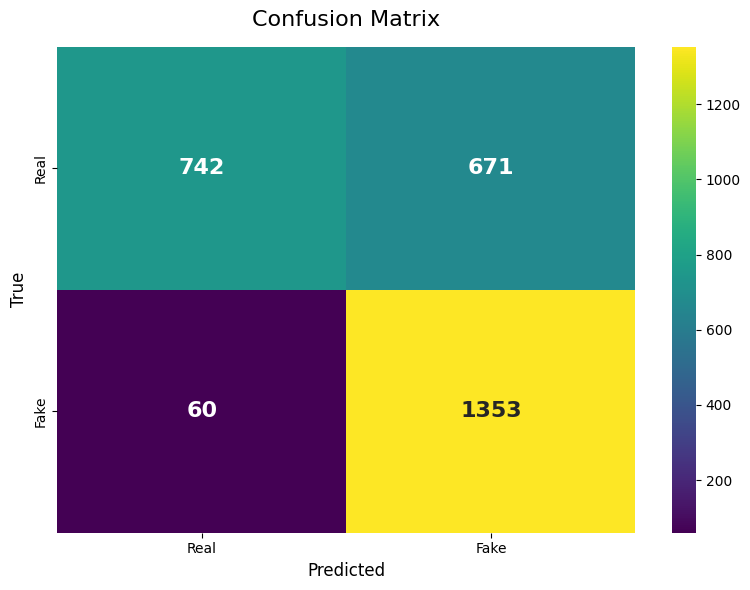

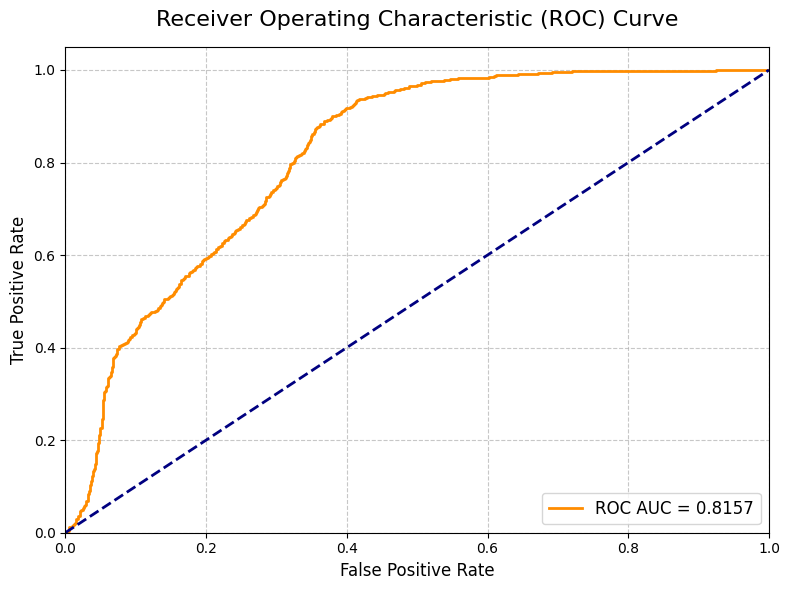

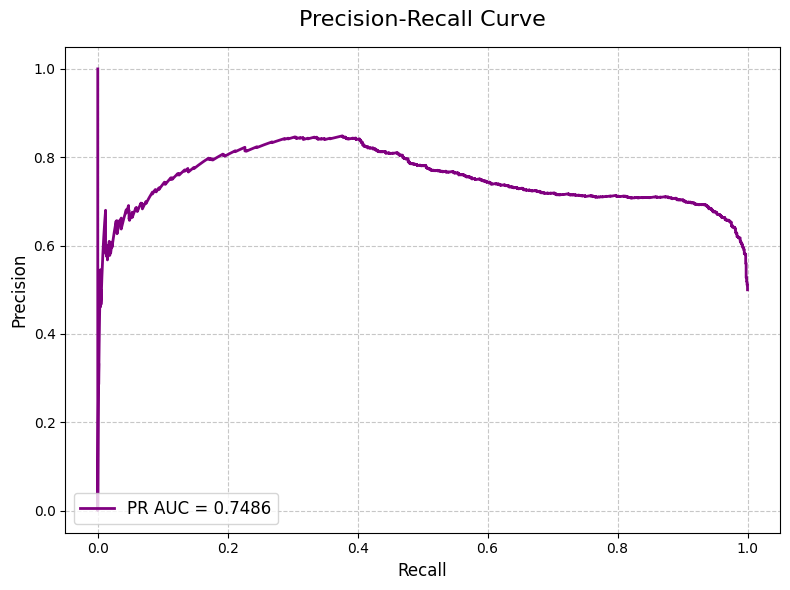

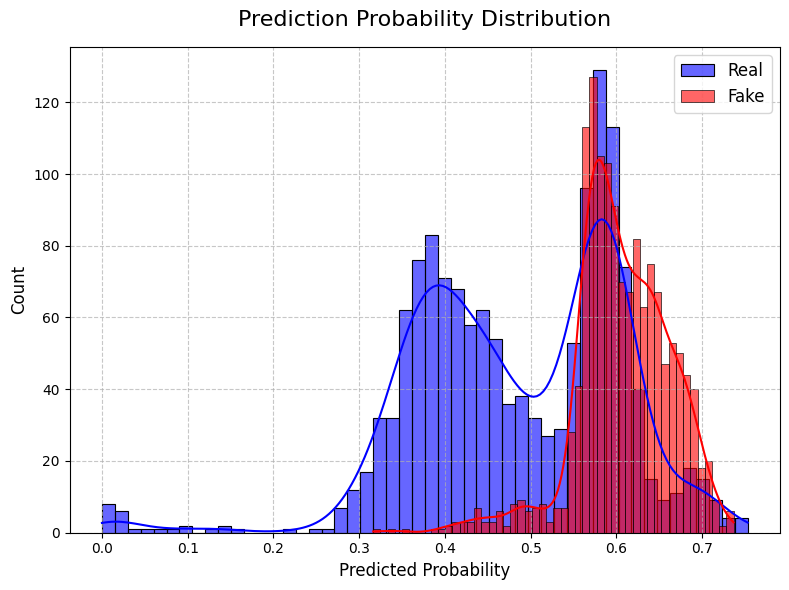

In [36]:

# Load the saved model
print(f"Loading model from {MODEL_PATH}...")
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'SincConv': SincConv, 'focal_loss_fn': focal_loss(gamma=1.5, alpha=0.5)}
)
print("Model loaded successfully!")
# Reuse the model for evaluation
val_ds = create_dataset(os.path.join(DATA_PATH, "validation"), augment=False, shuffle=False)
evaluate_model(val_ds, model)

In [40]:
# Testing Fuction 
def test_audio_folder(folder_path, model):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            audio = process_audio(tf.convert_to_tensor(file_path))
            audio = tf.expand_dims(audio, 0)
            prediction = model.predict(audio, verbose=0)[0][0]
            label = "fake" if prediction > 0.5 else "real"
            confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100
            print(f"\nTesting: {file_path}\nPrediction: {label} (Confidence: {confidence:.2f}%)")
# Path to your test folder (modify as needed)
test_folder_path = os.path.join(DATA_PATH, "test")
y = test_audio_folder(test_folder_path , model)


Testing: data\test\file33.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 59.15%)

Testing: data\test\file35.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 57.23%)

Testing: data\test\file40.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 55.23%)

Testing: data\test\file41.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 64.74%)

Testing: data\test\file61.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 64.13%)

Testing: data\test\file65.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 62.27%)

Testing: data\test\file71.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 61.88%)

Testing: data\test\file72.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav
Prediction: fake (Confidence: 63.21%)

Testing: data\test\file77.wav_16k.wav_norm.wav_mono.wav_silence.wav_2se